# Extra Boosting MSE dataset — large-variant test

Validates the Go ExtraBoost core (via the Python bridge) on the high-resolution dataset `mse_dataset_g128_tol015_nocatch_with_obs.csv`.

## Imports and paths

In [1]:
from pathlib import Path
import sys
import importlib
import json
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

NB_DIR = Path.cwd().resolve()
REPO_ROOT = NB_DIR.parent.parent
PYTHON_PATH = REPO_ROOT / 'python'
if str(PYTHON_PATH) not in sys.path:
    sys.path.insert(0, str(PYTHON_PATH))

from extra_boost_py import bridge as _bridge_module
from extra_boost_py import booster as _booster_module

importlib.reload(_bridge_module)
importlib.reload(_booster_module)

from extra_boost_py.go_lib import build_shared
from extra_boost_py.booster import BoosterParams, ExtraBooster


## Load the large dataset

In [2]:
DATA_PATH = REPO_ROOT / 'datasets/mse/mse_dataset_g128_tol015_nocatch_with_obs.csv'
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH}')

df = pd.read_csv(DATA_PATH)
print(f'Loaded {len(df):,} rows / {df.shape[1]} columns from {DATA_PATH.name}')
df.head()


Loaded 9,992 rows / 14 columns from mse_dataset_g128_tol015_nocatch_with_obs.csv


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,e_1,e_2,e_3,e_4,t,y,y_obs
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.117446,-0.399429,0.916764,0.117446,0.189325,0.189655
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.221779,-0.995645,0.093230,0.221779,0.995575,0.991379
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.257127,0.285912,0.958256,0.257127,0.569620,0.560345
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.854618,-0.949424,0.313997,0.854618,0.368520,0.370690
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.564994,0.024616,-0.999697,0.564994,0.130619,0.129310


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
f_1,9992.0,0.045637,0.208706,0.000000,0.000000,0.000000,0.000000,1.000000
f_2,9992.0,0.223279,0.416464,0.000000,0.000000,0.000000,0.000000,1.000000
f_3,9992.0,0.362790,0.480829,0.000000,0.000000,0.000000,1.000000,1.000000
f_4,9992.0,0.412930,0.492385,0.000000,0.000000,0.000000,1.000000,1.000000
f_5,9992.0,0.455064,0.498002,0.000000,0.000000,0.000000,1.000000,1.000000
f_6,9992.0,0.469976,0.499123,0.000000,0.000000,0.000000,1.000000,1.000000
f_7,9992.0,0.500000,0.500025,0.000000,0.000000,0.500000,1.000000,1.000000
e_1,9992.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
e_2,9992.0,0.495107,0.295693,0.000000,0.245154,0.472349,0.752993,1.000000
e_3,9992.0,0.031260,0.698170,-1.000000,-0.642665,0.085415,0.745555,1.000000


## Data exploration

Quick plots to understand the target trajectory and the train/test split used for model training.

In [4]:
time_col = 't'
target_col = 'y'
observed_col = 'y_obs' if 'y_obs' in df.columns else None

mask_train = df[time_col] < 0.5
mask_test = ~mask_train

print(f'Train rows: {mask_train.sum():,}')
print(f'Test rows: {mask_test.sum():,}')
if observed_col:
    print(f'Observed column detected: {observed_col}')


Train rows: 5,016
Test rows: 4,976
Observed column detected: y_obs


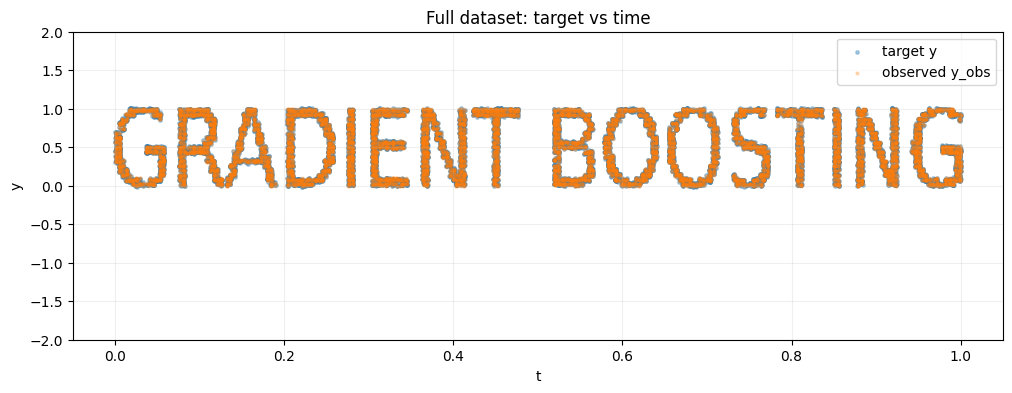

In [5]:
plt.figure(figsize=(12, 4))
plt.scatter(df[time_col], df[target_col], s=6, alpha=0.35, label='target y')
if observed_col:
    plt.scatter(df[time_col], df[observed_col], s=4, alpha=0.25, label='observed y_obs')
plt.title('Full dataset: target vs time')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.2)
plt.ylim(-2, 2)
plt.show()


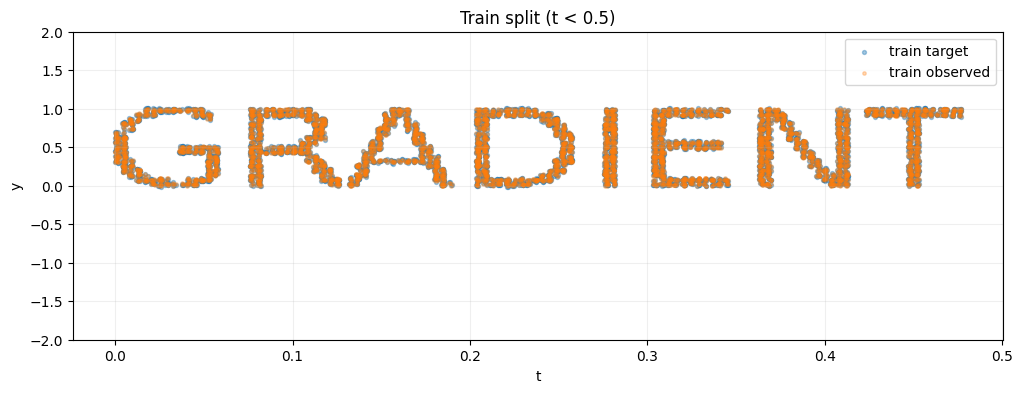

In [6]:
plt.figure(figsize=(12, 4))
plt.scatter(df.loc[mask_train, time_col], df.loc[mask_train, target_col], s=8, alpha=0.4, label='train target')
if observed_col:
    plt.scatter(df.loc[mask_train, time_col], df.loc[mask_train, observed_col], s=6, alpha=0.3, label='train observed')
plt.title('Train split (t < 0.5)')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.2)
plt.ylim(-2, 2)
plt.show()


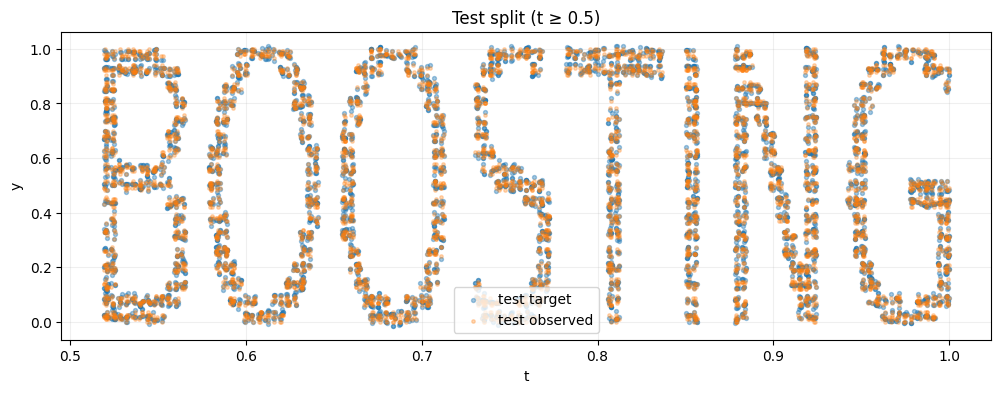

In [7]:
plt.figure(figsize=(12, 4))
plt.scatter(df.loc[mask_test, time_col], df.loc[mask_test, target_col], s=8, alpha=0.4, label='test target')
if observed_col:
    plt.scatter(df.loc[mask_test, time_col], df.loc[mask_test, observed_col], s=6, alpha=0.3, label='test observed')
plt.title('Test split (t ≥ 0.5)')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


### Static component slices

Inspect component-level traces defined by the binary static parameters `f_*`.

In [8]:
component_cols = sorted([col for col in df.columns if col.startswith('f_')])
component_summary = (
    df.groupby(component_cols)
    .size()
    .rename('count')
    .sort_values(ascending=False)
)
component_summary.head(6).reset_index()


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,count
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,412
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,343
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,340
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,331
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,319


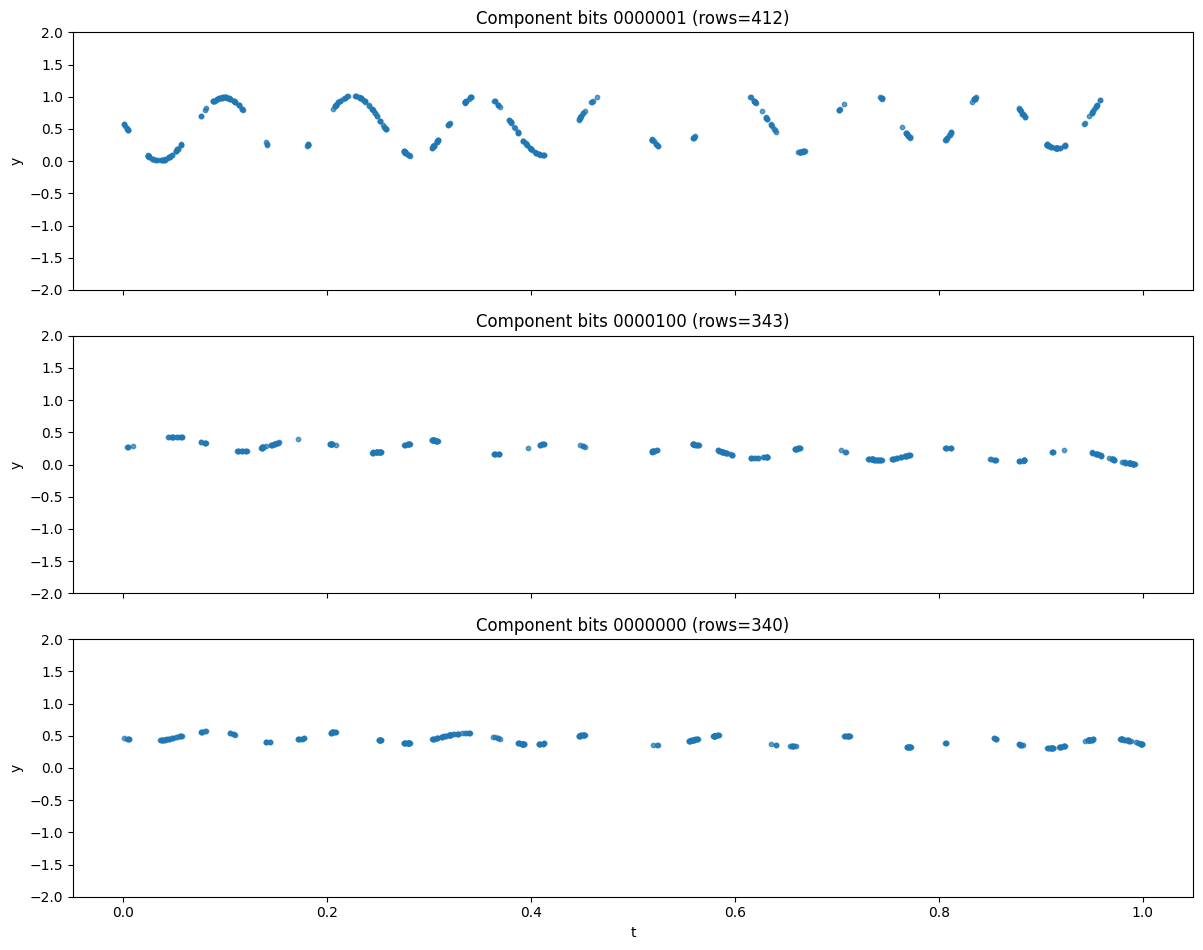

In [9]:
top_components = component_summary.head(3)
fig, axes = plt.subplots(len(top_components), 1, figsize=(12, 3.2 * len(top_components)), sharex=True)
if len(top_components) == 1:
    axes = [axes]
for ax, (bits, count) in zip(axes, top_components.items()):
    mask_component = np.logical_and.reduce([df[col] == bit for col, bit in zip(component_cols, bits)])
    label_bits = ''.join(str(int(bit)) for bit in bits)
    ax.scatter(df.loc[mask_component, time_col], df.loc[mask_component, target_col], s=10, alpha=0.7)
    ax.set_ylim(-2, 2)
    ax.set_ylabel('y')
    ax.set_title(f'Component bits {label_bits} (rows={count:,})')
ax.set_xlabel('t')
plt.tight_layout()
plt.show()


## Prepare numpy views for the bridge

In [10]:
feature_cols_inter = sorted([col for col in df.columns if col.startswith('f_')])
feature_cols_extra = sorted([col for col in df.columns if col.startswith('e_')])

print('Interaction features:', feature_cols_inter)
print('Extra features:', feature_cols_extra)
if observed_col:
    print('Observed column:', observed_col)

def contiguous(array):
    return np.ascontiguousarray(array, dtype=np.float64)

train_features_inter = contiguous(df.loc[mask_train, feature_cols_inter].to_numpy())
train_features_extra = contiguous(df.loc[mask_train, feature_cols_extra].to_numpy())
train_target = contiguous(df.loc[mask_train, target_col].to_numpy())

test_features_inter = contiguous(df.loc[mask_test, feature_cols_inter].to_numpy())
test_features_extra = contiguous(df.loc[mask_test, feature_cols_extra].to_numpy())
test_target = contiguous(df.loc[mask_test, target_col].to_numpy())

if observed_col:
    train_observed = contiguous(df.loc[mask_train, observed_col].to_numpy())
    test_observed = contiguous(df.loc[mask_test, observed_col].to_numpy())
else:
    train_observed = test_observed = None

train_features_inter.shape, test_features_inter.shape


Interaction features: ['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7']
Extra features: ['e_1', 'e_2', 'e_3', 'e_4']
Observed column: y_obs


((5016, 7), (4976, 7))

## Train ExtraBoost and inspect metrics

In [11]:
build_shared()

max_depth_values = [1, 2, 5, 7, 9]

monitor_datasets = [
    (train_features_inter, train_features_extra, train_target, 'train'),
    (test_features_inter, test_features_extra, test_target, 'test'),
]

training_runs = []


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    diff = y_true - y_pred
    return float(np.sqrt(np.mean(diff * diff)))


for depth in max_depth_values:
    params = BoosterParams(
        n_stages=48,
        learning_rate=0.3,
        max_depth=depth,
        loss='mse',
    )

    booster = ExtraBooster.train(
        train_features_inter,
        train_features_extra,
        train_target,
        params=params,
        monitor_datasets=monitor_datasets,
    )

    train_predictions = booster.predict(train_features_inter, train_features_extra)
    test_predictions = booster.predict(test_features_inter, test_features_extra)

    rmse_train = rmse(train_target, train_predictions)
    rmse_test = rmse(test_target, test_predictions)
    rmse_train_obs = rmse(train_observed, train_predictions) if train_observed is not None else None
    rmse_test_obs = rmse(test_observed, test_predictions) if test_observed is not None else None

    with tempfile.NamedTemporaryFile(suffix='.json', delete=False) as tmp_file:
        curves_path = Path(tmp_file.name)

    booster.dump_learning_curves(curves_path)
    with curves_path.open('r', encoding='utf-8') as f:
        learning_curves_payload = json.load(f)
    curves_path.unlink(missing_ok=True)

    run_payload = {
        'depth': depth,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'curve_titles': learning_curves_payload.get('Titles', []),
        'curve_values': np.asarray(learning_curves_payload.get('Values', []), dtype=float),
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'rmse_train_obs': rmse_train_obs,
        'rmse_test_obs': rmse_test_obs,
    }
    training_runs.append(run_payload)

    line = f"[depth={depth}] Train RMSE (y)={rmse_train:.6f} | Test RMSE (y)={rmse_test:.6f}"
    if rmse_train_obs is not None:
        line += f" | Observed RMSE train={rmse_train_obs:.6f}, test={rmse_test_obs:.6f}"
    print(line)

    booster.close()


[depth=1] Train RMSE (y)=0.293962 | Test RMSE (y)=0.335799 | Observed RMSE train=0.293720, test=0.335946
[depth=2] Train RMSE (y)=0.233053 | Test RMSE (y)=0.311611 | Observed RMSE train=0.232900, test=0.311778
[depth=5] Train RMSE (y)=0.025205 | Test RMSE (y)=0.209352 | Observed RMSE train=0.026259, test=0.209477
[depth=7] Train RMSE (y)=0.000003 | Test RMSE (y)=0.044576 | Observed RMSE train=0.008303, test=0.045427
[depth=9] Train RMSE (y)=0.000003 | Test RMSE (y)=0.044576 | Observed RMSE train=0.008303, test=0.045427


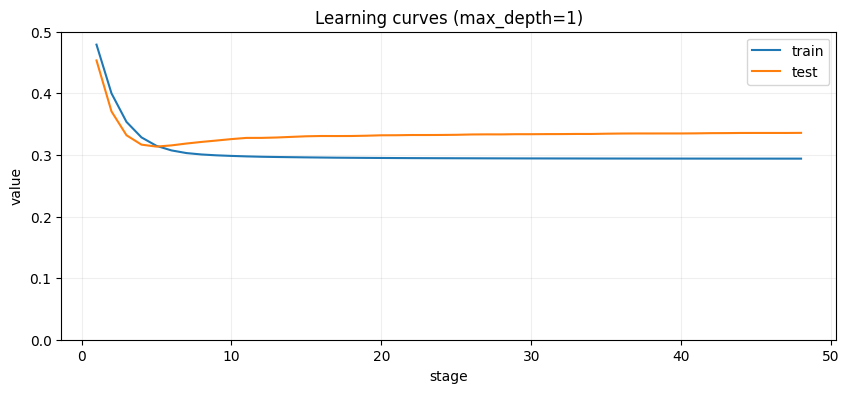

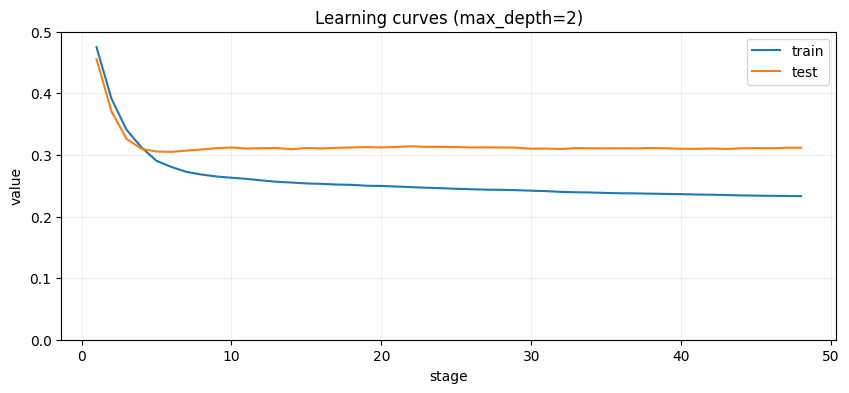

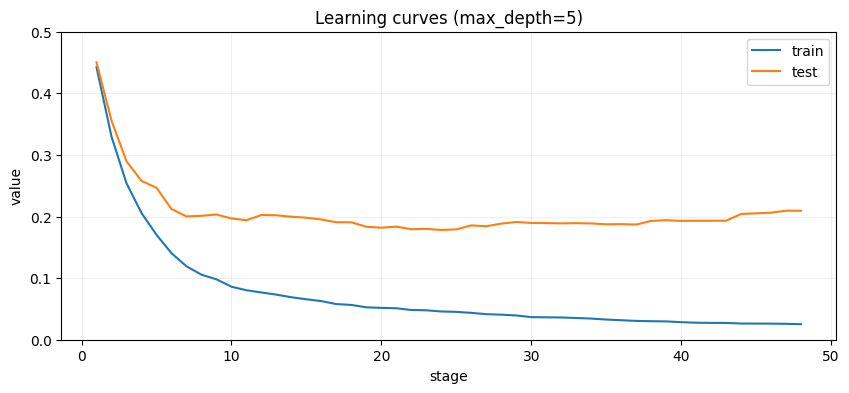

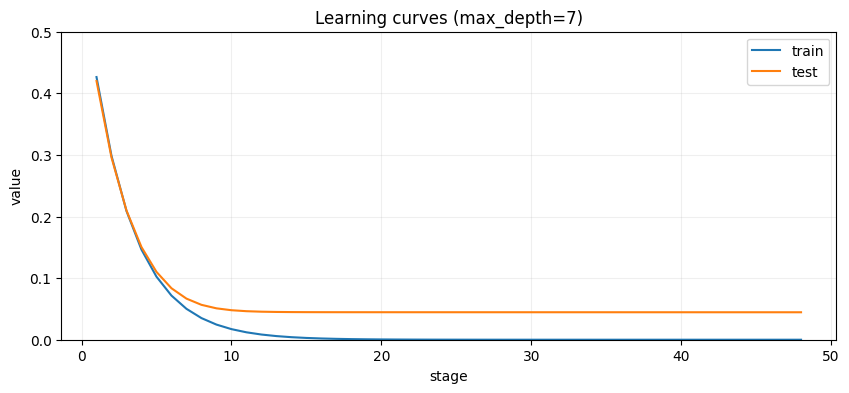

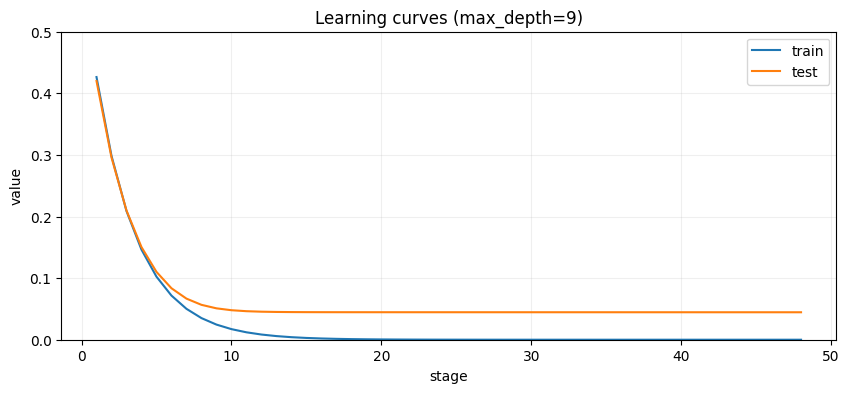

In [12]:
if not training_runs:
    print('Learning curves unavailable: no training runs logged.')
else:
    for run in training_runs:
        curve_values = run['curve_values']
        curve_titles = run['curve_titles']
        if curve_values.size == 0 or curve_values.ndim != 2:
            print(f"[depth={run['depth']}] Learning curve payload is empty.")
            continue

        stages = curve_values.shape[0]
        x_axis = np.arange(1, stages + 1)
        plt.figure(figsize=(10, 4))
        titles = curve_titles if curve_titles else [f'curve_{i}' for i in range(curve_values.shape[1])]
        for col, title in zip(curve_values.T, titles):
            plt.plot(x_axis, col, label=title)
        plt.xlabel('stage')
        plt.ylabel('value')
        plt.title(f"Learning curves (max_depth={run['depth']})")
        plt.grid(True, alpha=0.2)
        plt.ylim(0, 0.5)
        plt.legend()


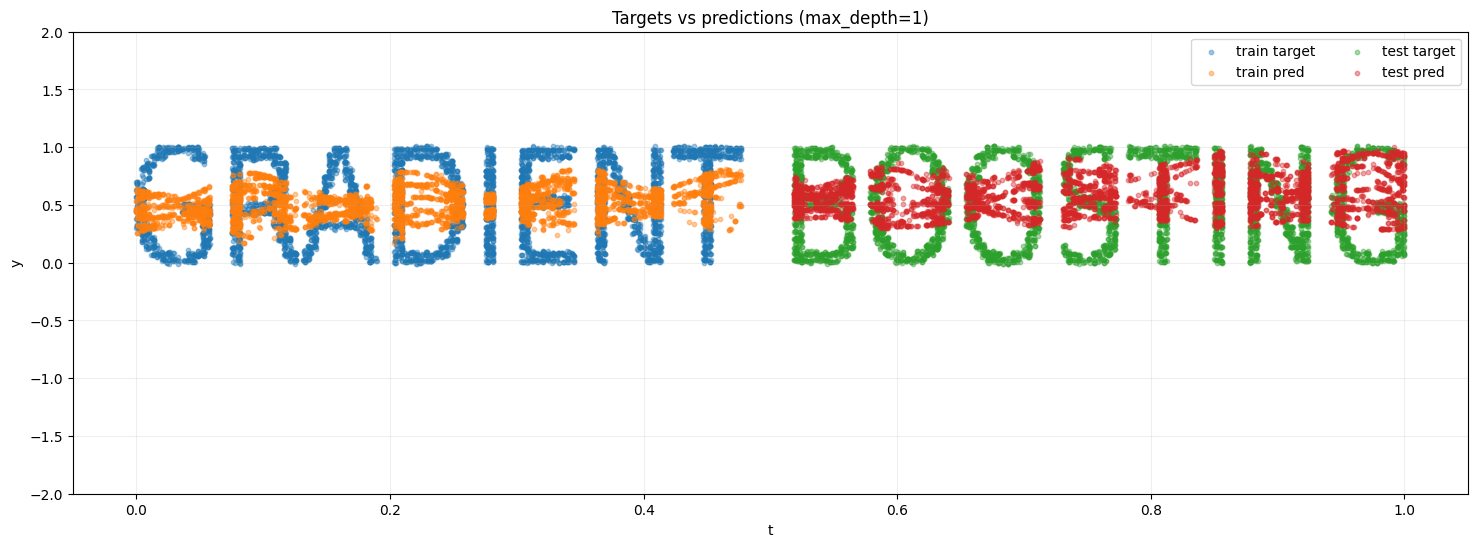

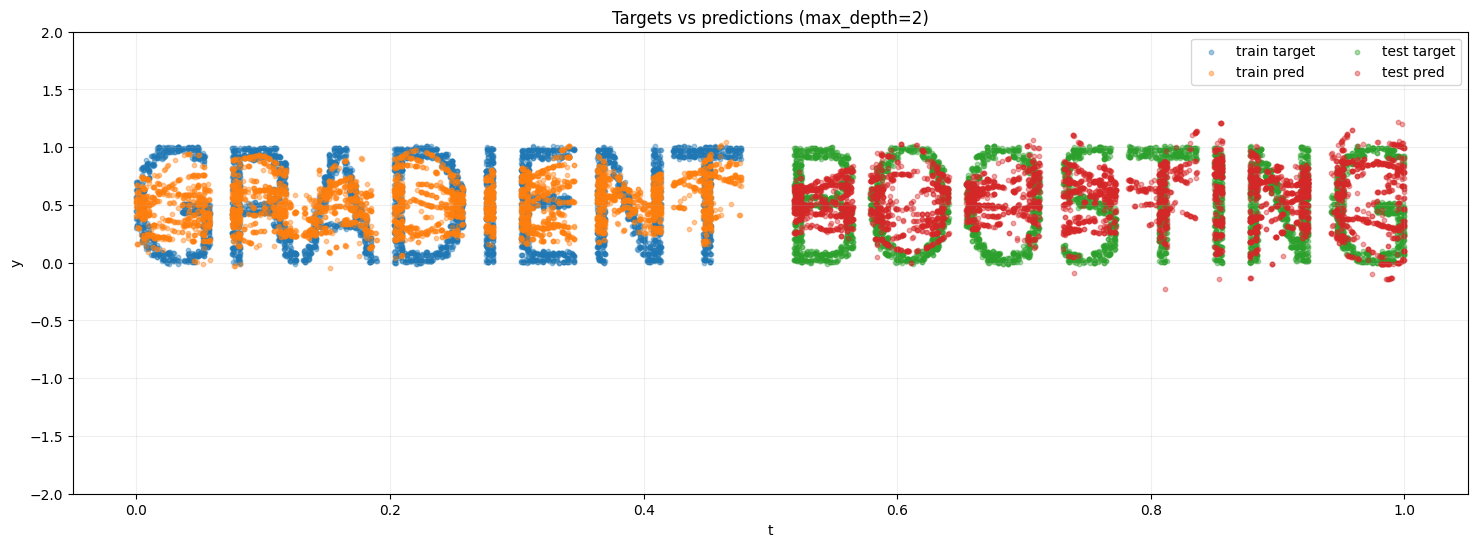

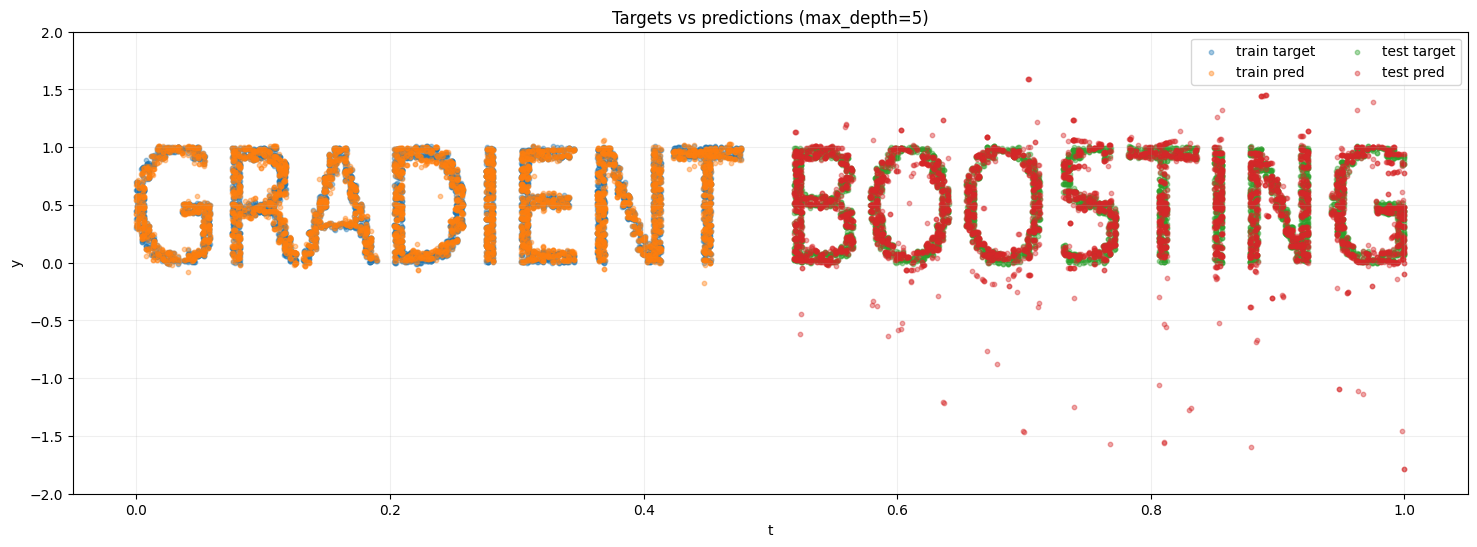

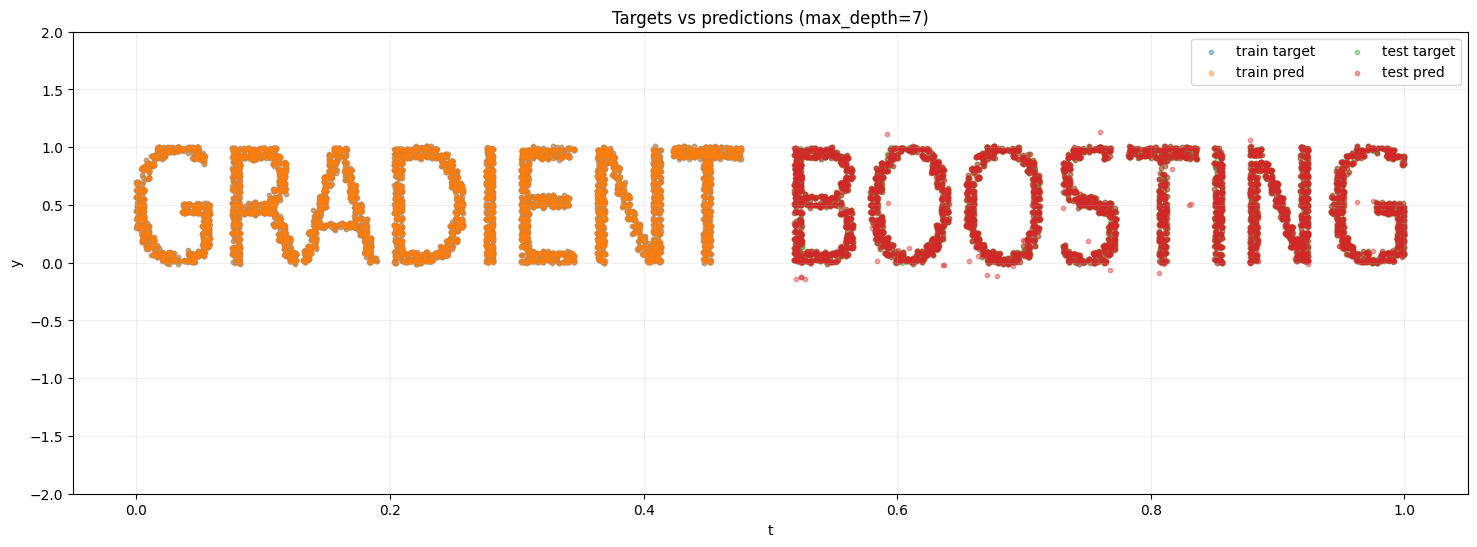

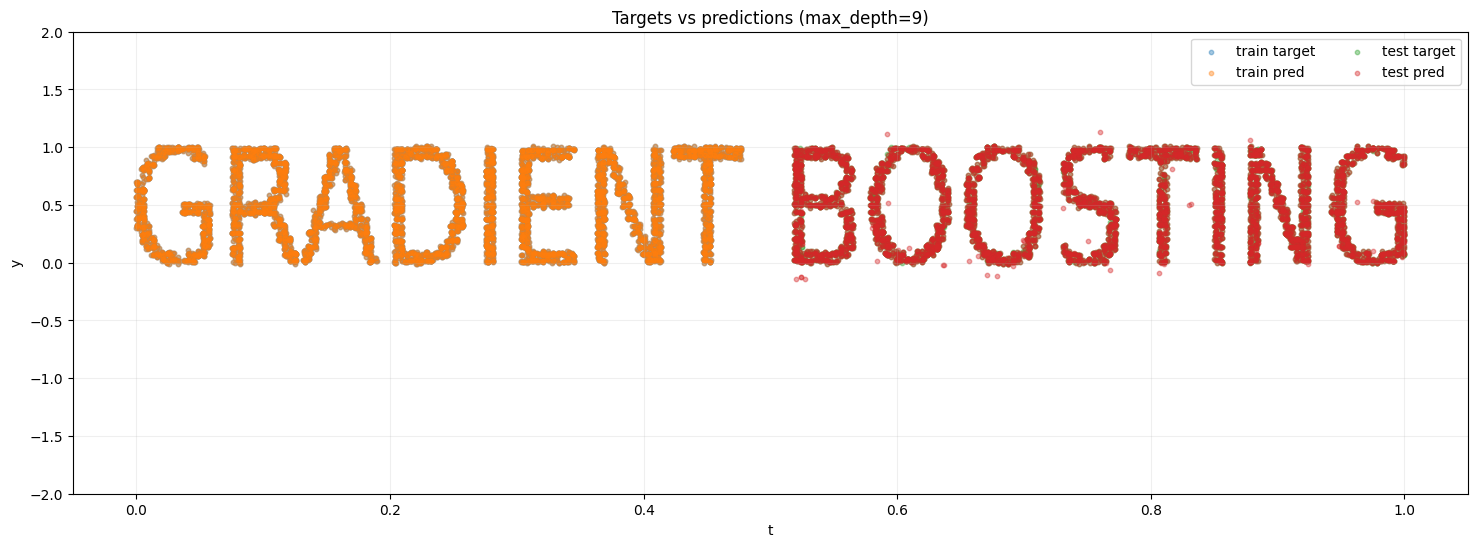

In [13]:
if not training_runs:
    print('No predictions captured: skipping scatter plots.')
else:
    for run in training_runs:
        depth = run['depth']
        train_predictions = run['train_predictions']
        test_predictions = run['test_predictions']

        plt.figure(figsize=(18, 6))
        plt.scatter(df.loc[mask_train, time_col], train_target, s=10, alpha=0.4, label='train target')
        plt.scatter(df.loc[mask_train, time_col], train_predictions, s=10, alpha=0.4, label='train pred')
        plt.scatter(df.loc[mask_test, time_col], test_target, s=10, alpha=0.4, label='test target')
        plt.scatter(df.loc[mask_test, time_col], test_predictions, s=10, alpha=0.4, label='test pred')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.title(f'Targets vs predictions (max_depth={depth})')
        plt.legend(ncol=2)
        plt.grid(True, alpha=0.2)
        plt.ylim(-2, 2)
        plt.show()


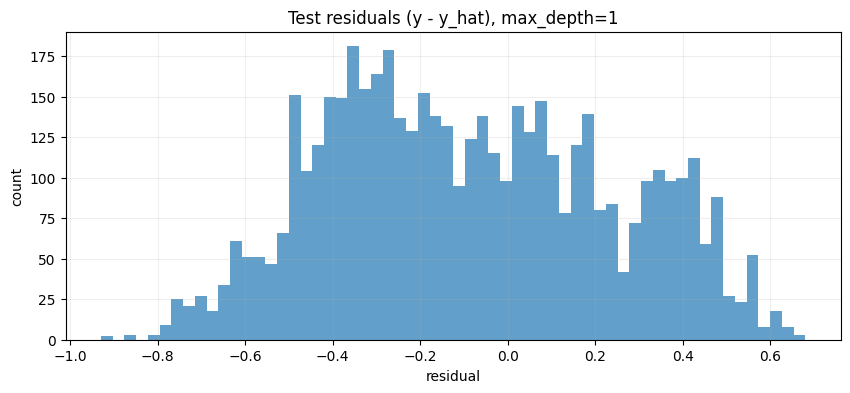

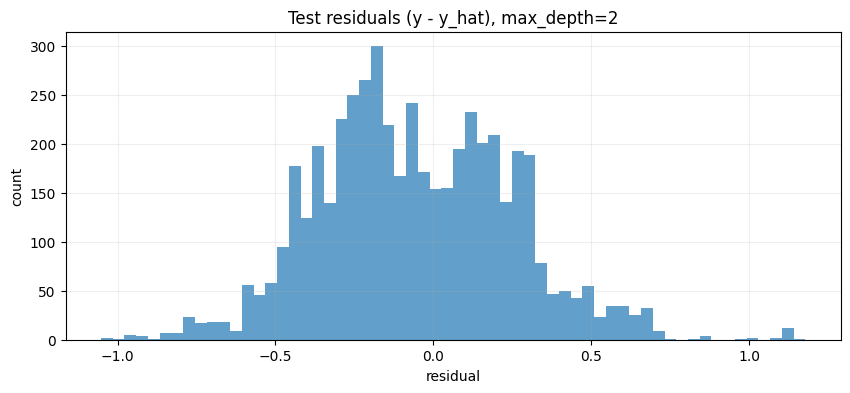

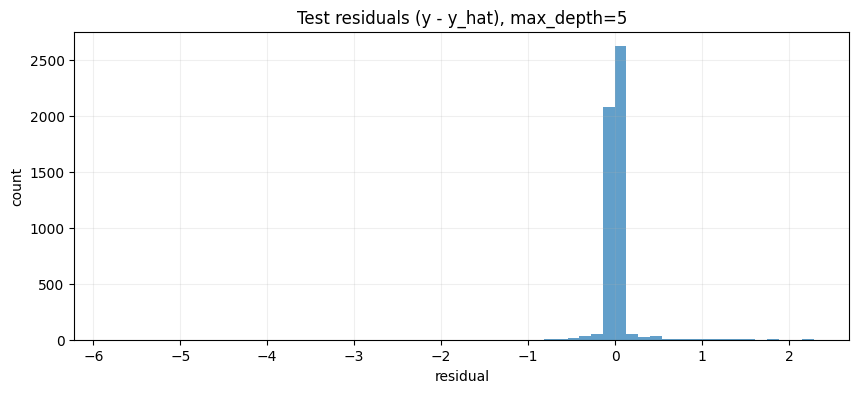

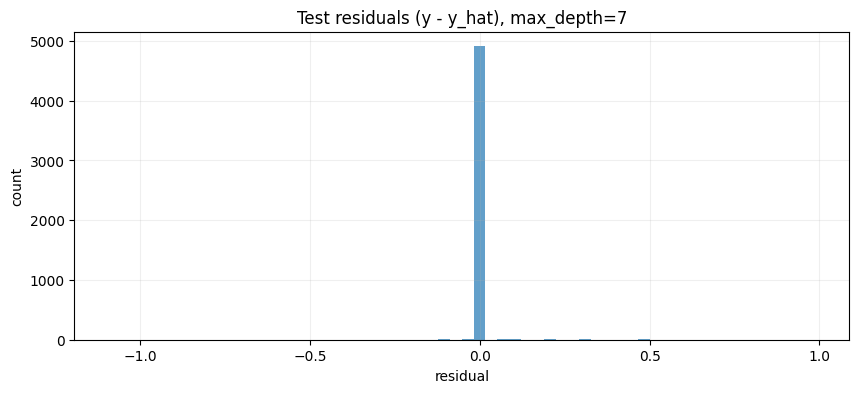

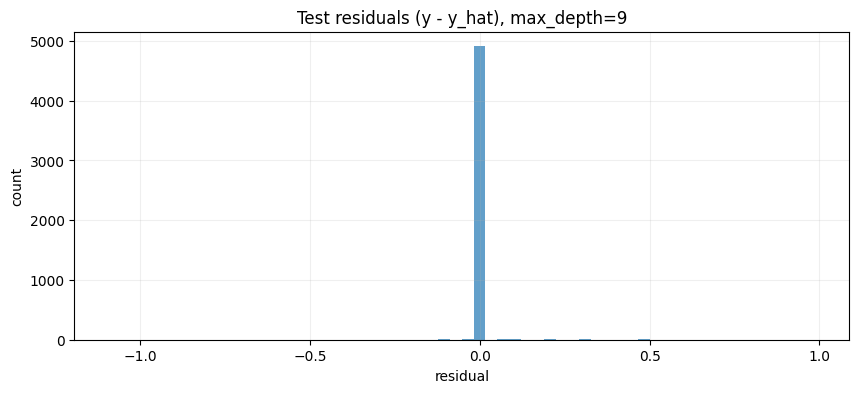

In [14]:
if not training_runs:
    print('Residual histograms unavailable: no training runs logged.')
else:
    for run in training_runs:
        depth = run['depth']
        residuals = test_target - run['test_predictions']
        plt.figure(figsize=(10, 4))
        plt.hist(residuals, bins=60, alpha=0.7)
        plt.title(f'Test residuals (y - y_hat), max_depth={depth}')
        plt.xlabel('residual')
        plt.ylabel('count')
        plt.grid(True, alpha=0.2)
        plt.show()
